In [3]:
!pip install keras

In [1]:
from tensorflow.keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten, Reshape, Input
import numpy as np


In [2]:
(X_train, _), (X_test, _) = mnist.load_data()
X_train = X_train.astype(np.float64)[:150] / 255.


11493376/11490434 [==============================] - 5s 0us/step


In [7]:
compression_level = 32  

In [8]:
input_im = Input(shape=(28,28,1))
layer0 = Reshape((28**2,))(input_im)
layer1 = Dense(4*28**2, activation='sigmoid')(layer0)
layer2 = Dense(compression_level, activation='relu')(layer1)

encoder = Model(input_im, layer2)

input_de = Input(shape=(compression_level,))
layer3 = Dense(4*28**2, activation='sigmoid', input_shape=(compression_level,))(input_de)
layer4 = Dense(28**2, activation='sigmoid')(layer3)
outlayer = Reshape((28,28,1))(layer4)

decoder = Model(input_de, outlayer)

In [10]:
autoencoder = Model(inputs=input_im, outputs=decoder(encoder(input_im)))
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [11]:
autoencoder.fit(X_train, X_train, 150, 200, shuffle=True)

Epoch 1/200
1/1 [==============================] - 85s 85s/step - loss: 0.7349
Epoch 2/200
1/1 [==============================] - 1s 704ms/step - loss: 0.3932
Epoch 3/200
1/1 [==============================] - 0s 205ms/step - loss: 0.2956
Epoch 4/200
1/1 [==============================] - 0s 210ms/step - loss: 0.2831
Epoch 5/200
1/1 [==============================] - 0s 220ms/step - loss: 0.2863
Epoch 6/200
1/1 [==============================] - 0s 231ms/step - loss: 0.2837
Epoch 7/200
1/1 [==============================] - 1s 630ms/step - loss: 0.2805
Epoch 8/200
1/1 [==============================] - 1s 832ms/step - loss: 0.2812
Epoch 9/200
1/1 [==============================] - 0s 277ms/step - loss: 0.2820
Epoch 10/200
1/1 [==============================] - 0s 207ms/step - loss: 0.2789
Epoch 11/200
1/1 [==============================] - 1s 571ms/step - loss: 0.2740
Epoch 12/200
1/1 [==============================] - 1s 769ms/step - loss: 0.2709
Epoch 13/200
1/1 [====================

In [14]:
import matplotlib.pyplot as plt

In [15]:
a = X_test[:100]

a = autoencoder.predict(a)

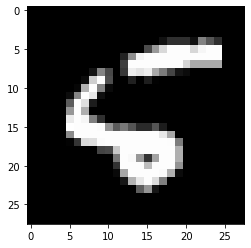

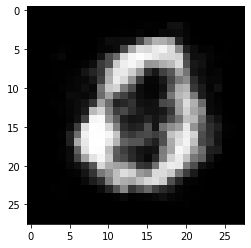

In [16]:
n=8

plt.imshow(X_test[n], cmap='gray')
plt.show()
plt.imshow(a[n], cmap='gray')
plt.show()

(100, 28, 28, 1)


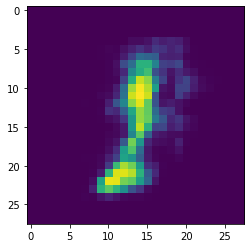

array([[  0.      ,   0.      ,   0.      ,  81.82926 ,   0.      ,
          0.      ,   0.      ,   8.145753,   0.      ,   0.      ,
          0.      ,  32.371708,   0.      ,  12.505445,  40.46909 ,
          0.      ,  45.265068,   0.      ,   0.      ,   0.      ,
          0.      ,   0.      ,  92.00907 ,   0.      ,  25.433105,
          0.      ,  43.003883, 110.74437 ,   0.      ,   0.      ,
          0.      ,   0.      ]], dtype=float32)

In [17]:
b = encoder.predict(a[:1])
print(a.shape)
b > 0
plt.imshow(decoder.predict(b>0)[0])
plt.show()
b

In [76]:
def compress(frame):
    import numpy as np
    frame = frame.astype(np.float64)/255.
    block_size = 28
    size = frame.shape[0] // block_size, frame.shape[1] // block_size
    im_size = np.array([*size, 0])*block_size
    im_size[2] = frame.shape[2]
    res_img = np.zeros(im_size)
    blocks = np.zeros((size[0]*size[1]*frame.shape[2], 28, 28, 1))
    for i in range(size[0]):
        for j in range(size[1]):
            for k in range(frame.shape[2]):
                blocks[i*size[1]*frame.shape[2]+j*frame.shape[2]+k] = frame[block_size*i:block_size*(i+1), block_size*j:block_size*(j+1), k:k+1]   
    result = autoencoder.predict(blocks.reshape((size[0]*size[1]*frame.shape[2], block_size, block_size, 1)))
    # print(result.shape)
    # return np.zeros(3)
    for i in range(size[0]):
        for j in range(size[1]):
            for k in range(frame.shape[2]):
                res_img[block_size*i:block_size*(i+1), block_size*j:block_size*(j+1), k:k+1] = result[i*size[1]*frame.shape[2]+j*frame.shape[2]+k]
    return res_img     

def split(frame):
    import numpy as np
    frame = frame.astype(np.float64)/255.
    block_size = 28
    size = frame.shape[0] // block_size, frame.shape[1] // block_size
    im_size = np.array([*size, 0])*block_size
    im_size[2] = 1
    res_img = np.zeros(im_size)
    blocks = np.zeros((size[0]*size[1], 28, 28, 1))
    for i in range(size[0]):
        for j in range(size[1]):
            blocks[i*size[1]+j] = frame[block_size*i:block_size*(i+1), block_size*j:block_size*(j+1), :1]   
    return blocks         

In [77]:
import cv2
cap = cv2.VideoCapture(0)

In [58]:
blocks = []
for i in range(400):
  _, frame = cap.read()
  blocks.append(split(frame))
  cv2.waitKey(1)
blocks = np.array(blocks).reshape((blocks.shape[0]*blocks.shape[1], 28, 28, 1))


AttributeError: 'list' object has no attribute 'shape'

In [38]:
autoencoder.fit(blocks, blocks, 150, 10, shuffle=True)

Epoch 1/10
998/998 [==============================] - 397s 394ms/step - loss: 0.4798
Epoch 2/10
998/998 [==============================] - 459s 460ms/step - loss: 0.4730
Epoch 3/10
998/998 [==============================] - 457s 458ms/step - loss: 0.4724
Epoch 4/10
998/998 [==============================] - 471s 472ms/step - loss: 0.4720
Epoch 5/10
998/998 [==============================] - 435s 436ms/step - loss: 0.4718
Epoch 6/10
998/998 [==============================] - 363s 363ms/step - loss: 0.4716
Epoch 7/10
998/998 [==============================] - 360s 361ms/step - loss: 0.4714
Epoch 8/10
998/998 [==============================] - 383s 384ms/step - loss: 0.4713
Epoch 9/10
998/998 [==============================] - 374s 375ms/step - loss: 0.4713
Epoch 10/10
998/998 [==============================] - 372s 372ms/step - loss: 0.4712


In [78]:
while 1:
    ret, frame = cap.read()
    res = compress(frame)
    # break
    cv2.imshow('scr', res)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break 
cap.release()
cv2.destroyAllWindows()

In [81]:
autoencoder.save("dump-ae.model")

INFO:tensorflow:Assets written to: dump-ae.model\assets
